Initial analysis of results on 40 vs rest for different datasets

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if "notebooks" in os.getcwd():
    home_dir = os.getcwd()

os.chdir(os.path.join("..", "results"))

raw_results = pd.read_csv("40vs_rest_cell_line_results.csv")

os.chdir(home_dir)

In [19]:
raw_results["dataset"] = [do.split("/")[-1].replace("matricies", "matrices").split("matrices_")[-1]
                          for do in raw_results["data_origin"].tolist()]

overview_only = raw_results[raw_results["Cell_line_id"]=="ALL_LINES"].copy()
lines_only = raw_results[raw_results["Cell_line_id"]!="ALL_LINES"].copy()
valid_only = lines_only[lines_only["data_split"]=="valid"].copy()

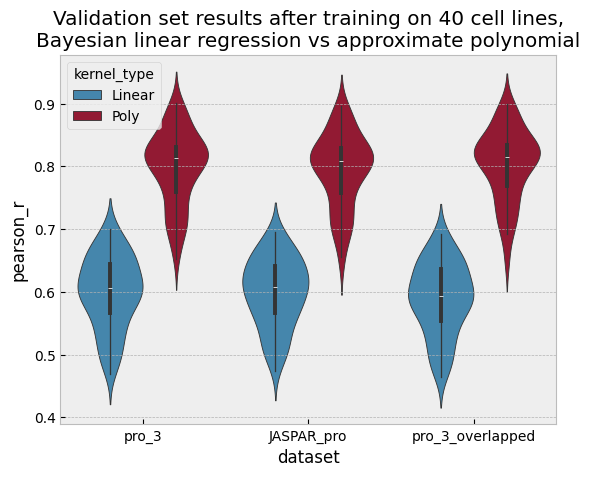

In [22]:
plt.style.use("bmh")
sns.violinplot(x="dataset", y="pearson_r", hue="kernel_type", data=valid_only)
plt.title("Validation set results after training on 40 cell lines,\nBayesian linear regression vs approximate polynomial")
plt.savefig("valid_set_results.png")